In [11]:
import numpy as np
import networkx as nx
from sklearn.linear_model import Lasso, LinearRegression
from scipy import sparse

# Data Generation
def network_generate(n, eta):
    G = nx.scale_free_graph(n)
    G.remove_edges_from(nx.selfloop_edges(G))
    edges_to_remove = []
    seen = set()
    for edge in G.edges:
        if (edge[0], edge[1]) in seen:
            edges_to_remove.append(edge)
        else:
            seen.add((edge[0], edge[1]))
    G.remove_edges_from(edges_to_remove)
    for edge in G.edges(data=True):
        edge[2]["weight"] = np.random.uniform(1.0 - eta, 1.0 + eta)
    A = nx.adjacency_matrix(G).todense().T
    k_in = np.zeros(n)
    for node in range(n):
        if G.in_degree(node) > 0:
            k_in[node] = sum(data["weight"] for _, _, data in G.in_edges(node, data=True))
    L = np.diag(k_in) - A
    delta = np.max(k_in)
    return G, A, L, delta, k_in

def data_generate(n, m, transient, time, beta, mu, sigma, C, L, delta, gamma):
    def rulkov_map(x):
        x = x.reshape(n, m).T
        return np.asarray([
            beta / (1 + x[0]**2) + x[1],
            x[1] - mu * x[0] - sigma
        ]).T.flatten()

    h = np.eye(m)
    h[1, 1] = 0  # Only couple u-component

    def net_dynamics(x):
        noise = gamma * np.random.uniform(-1, 1, n * m)
        return rulkov_map(x) - (C / delta) * sparse.kron(L, h).dot(x) + noise

    x0 = np.random.uniform(0.0, 1.0, n * m)
    for _ in range(transient):
        x0 = rulkov_map(x0)
    for _ in range(transient):
        x0 = net_dynamics(x0)
    x = np.zeros((n * m, time))
    x[:, 0] = x0
    for t in range(time - 1):
        x[:, t + 1] = net_dynamics(x[:, t])
    return x.reshape(n, m, time)

# Reconstruction
def get_basis_library(U, V):
    ones = np.ones_like(U)
    return np.column_stack([
        ones, U, V, U**2, V**2, U*V, 1/(1 + U**2), U/(1 + U**2), V/(1 + U**2)
    ])

def get_predicted_models(x, alpha=0.001, max_iter=10000):
    n, m, t = x.shape
    num_basis = get_basis_library(x[0, 0, :], x[0, 1, :]).shape[1]
    models = np.zeros((n, 2 * num_basis))
    for i in range(n):
        U = x[i, 0, :-1]
        V = x[i, 1, :-1]
        U_next = x[i, 0, 1:]
        V_next = x[i, 1, 1:]
        library_u = get_basis_library(U, V)
        library_v = get_basis_library(U, V)
        lasso_u = Lasso(alpha=alpha, max_iter=max_iter, fit_intercept=False)
        lasso_u.fit(library_u, U_next)
        lasso_v = Lasso(alpha=alpha, max_iter=max_iter, fit_intercept=False)
        lasso_v.fit(library_v, V_next)
        models[i, :num_basis] = lasso_u.coef_
        models[i, num_basis:] = lasso_v.coef_
    return models

def classify_nodes(models):
    n, _ = models.shape
    var = np.var(models, axis=0)
    var[var == 0] = 1e-10  # Avoid division by zero
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist_matrix[i, j] = np.sqrt(np.sum((models[i] - models[j])**2 / var))
    dist_sum = np.sum(dist_matrix, axis=1)
    hub_id = np.argmax(dist_sum)  # Hub: highest distance (most distinct)
    ld_id = np.argmin(dist_sum)   # Low-degree: lowest distance (most similar)
    return hub_id, ld_id, dist_matrix

def learn_local_dynamics(models, dist_sum):
    num_basis = models.shape[1] // 2
    ld_indices = np.argsort(dist_sum)[:min(5, len(dist_sum))]  # Lowest distances
    ld_models = models[ld_indices]
    f_u = np.mean(ld_models[:, :num_basis], axis=0)
    f_v = np.mean(ld_models[:, num_basis:], axis=0)
    return f_u, f_v

def learn_coupling(x, hub_id, f_u, f_v):
    U_hub = x[hub_id, 0, 1:]
    V_hub = x[hub_id, 1, 1:]
    U_prev = x[hub_id, 0, :-1]
    V_prev = x[hub_id, 1, :-1]
    library = get_basis_library(U_prev, V_prev)
    Y = U_hub - (f_u @ library.T)
    reg = LinearRegression(fit_intercept=True)
    reg.fit(U_prev.reshape(-1, 1), Y)
    alpha_h = reg.coef_[0]
    c = reg.intercept_
    return alpha_h, c

def reconstruct_laplacian(x, f_u, f_v, alpha_h, c, alpha=0.0003):
    n, m, t = x.shape
    U_all = x[:, 0, :-1]  # (n, T-1)
    H_library = alpha_h * U_all.T  # (T-1, n)
    L_pred = np.zeros((n, n))
    for i in range(n):
        U = x[i, 0, :-1]
        V = x[i, 1, :-1]
        library_local = get_basis_library(U, V)
        Y = x[i, 0, 1:] - (f_u @ library_local.T)
        lasso = Lasso(alpha=alpha, max_iter=10000, fit_intercept=True)
        lasso.fit(H_library, -Y)
        L_pred[i] = lasso.coef_
    # Post-process: set diagonal to make row sums 0
    off_diag = L_pred - np.diag(np.diag(L_pred))
    k_pred = -np.sum(off_diag, axis=1)
    L_pred = off_diag + np.diag(k_pred)
    return L_pred

# Performance Metrics
def compute_performance_metrics(L_true, L_pred, epsilon=0.0001):
    n = L_true.shape[0]
    L_true_off = L_true - np.diag(np.diag(L_true))
    L_pred_off = L_pred - np.diag(np.diag(L_pred))
    positives_mask = np.abs(L_true_off) > epsilon
    negatives_mask = np.abs(L_true_off) <= epsilon
    fn = np.sum(positives_mask & (np.abs(L_pred_off) <= epsilon))
    fp = np.sum(negatives_mask & (np.abs(L_pred_off) > epsilon))
    positives = np.sum(positives_mask)
    negatives = n**2 - n - positives
    fnr = fn / positives if positives > 0 else 0.0
    fpr = fp / negatives if negatives > 0 else 0.0
    return fnr, fpr

In [14]:
# Main Execution
n = 20
m = 2
time = 1000
transient = 14000
beta = 4.1
mu = 0.001
sigma = 0.001
C = 0.1
gamma = 0.001
eta = 0.2

G, A, L, delta, k_in = network_generate(n, eta)
x = data_generate(n, m, transient, time, beta, mu, sigma, C, L, delta, gamma)

models = get_predicted_models(x)
hub_id, ld_id, dist_matrix = classify_nodes(models)
dist_sum = np.sum(dist_matrix, axis=1)
f_u, f_v = learn_local_dynamics(models, dist_sum)
alpha_h, c = learn_coupling(x, hub_id, f_u, f_v)
L_pred = reconstruct_laplacian(x, f_u, f_v, alpha_h, c)

# Performance Metrics
fnr, fpr = compute_performance_metrics(L, L_pred)
print(f"Hub ID: {hub_id}, Low-Degree ID: {ld_id}")
print(f"Fitted H slope: {alpha_h}, intercept: {c}")
print(f"Reconstructed Graph has {np.sum(np.abs(L_pred - np.diag(np.diag(L_pred))) > 0.0001)} edges")
print(f"False Negative Rate (FNR): {fnr:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"FNR/FPR: {fnr/fpr:.4f}")

Hub ID: 2, Low-Degree ID: 17
Fitted H slope: -0.09786788474524463, intercept: -0.09779333935830606
Reconstructed Graph has 35 edges
False Negative Rate (FNR): 0.0000
False Positive Rate (FPR): 0.0254
FNR/FPR: 0.0000


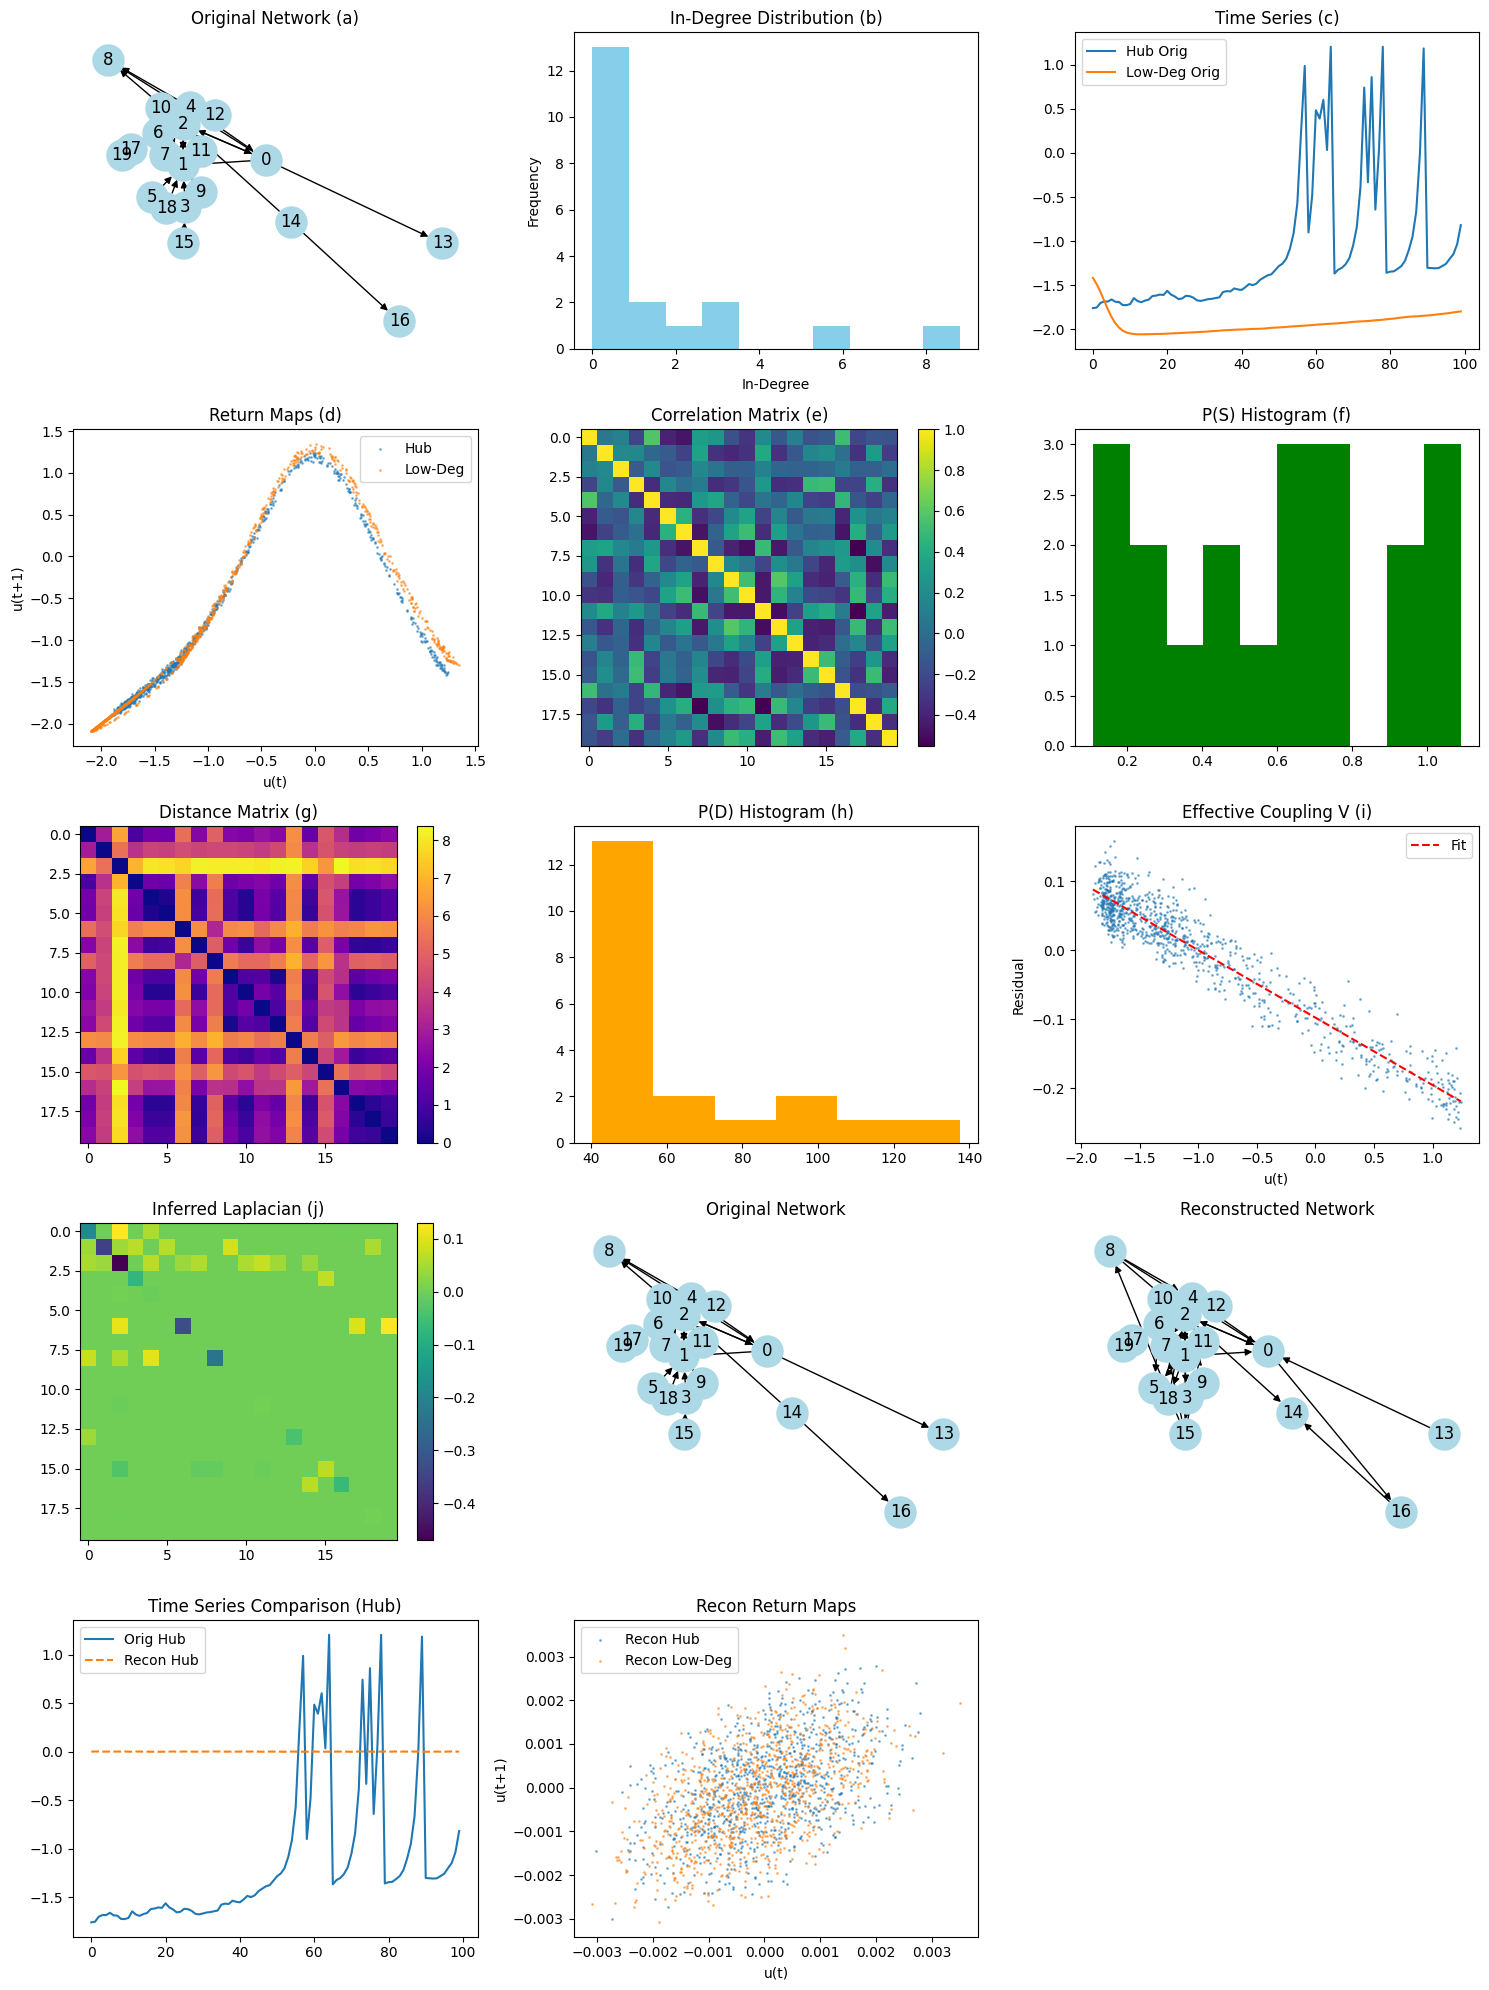

In [18]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Compute pairwise Pearson correlations (SM Fig. 1(e,f))
u_data = x[:, 0, :]  # u-components for all nodes
corr_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        corr_matrix[i, j] = pearsonr(u_data[i], u_data[j])[0]
corr_sum = np.sum(corr_matrix, axis=1)

# Histogram P(D) from dist_sum (SM Fig. 1(h))
hist_d, bins_d = np.histogram(dist_sum, bins='auto')

# Effective coupling V from hub residual (SM Fig. 1(i))
U_hub = x[hub_id, 0, 1:]
V_hub = x[hub_id, 1, 1:]
U_prev = x[hub_id, 0, :-1]
V_prev = x[hub_id, 1, :-1]
library_hub = get_basis_library(U_prev, V_prev)
Y_hub = U_hub - (f_u @ library_hub.T)
# For plot, sort by U_prev for line fit visualization
sort_idx = np.argsort(U_prev)
U_sorted = U_prev[sort_idx]
Y_sorted = Y_hub[sort_idx]

# Simulate data from reconstructed network
def rulkov_map_recon(x_flat):
    x = x_flat.reshape(n, m)
    u_next = np.zeros(n)
    v_next = np.zeros(n)
    for i in range(n):
        u_i = x[i, 0]  # Current u state
        v_i = x[i, 1]  # Current v state
        lib = get_basis_library(np.array([u_i]), np.array([v_i]))[0]  # Convert to array, take first row
        u_next[i] = np.dot(f_u, lib)
        v_next[i] = np.dot(f_v, lib)
    return np.stack([u_next, v_next]).T.flatten()

h_recon = np.eye(m)
h_recon[1, 1] = 0
def net_dynamics_recon(x_flat):
    x = x_flat.reshape(n, m)
    coupling = alpha_h * x[:, 0] + c
    lap_term = L_pred @ coupling
    noise = gamma * np.random.uniform(-1, 1, n * m)
    return rulkov_map_recon(x_flat) - (C / delta) * sparse.kron(L_pred, h_recon).dot(x_flat) + noise

x0_recon = np.random.uniform(0.0, 1.0, n * m)
for _ in range(transient // 10):  # Shorter transient for recon
    x0_recon = rulkov_map_recon(x0_recon)
for _ in range(transient // 10):
    x0_recon = net_dynamics_recon(x0_recon)
x_recon = np.zeros((n * m, time))
x_recon[:, 0] = x0_recon
for t in range(time - 1):
    x_recon[:, t + 1] = net_dynamics_recon(x_recon[:, t])
x_recon = x_recon.reshape(n, m, time)

# Plots inspired by SM Fig. 1
plt.figure(figsize=(15, 20))

# (a) Original network graph
plt.subplot(5, 3, 1)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', arrows=True, node_size=500)
plt.title('Original Network (a)')

# (b) In-degree distribution
plt.subplot(5, 3, 2)
plt.hist(k_in, bins=10, color='skyblue')
plt.title('In-Degree Distribution (b)')
plt.xlabel('In-Degree')
plt.ylabel('Frequency')

# (c) Time series of hub and low-degree
plt.subplot(5, 3, 3)
plt.plot(x[hub_id, 0, :100], label='Hub Orig')
plt.plot(x[ld_id, 0, :100], label='Low-Deg Orig')
plt.title('Time Series (c)')
plt.legend()

# (d) Return maps
plt.subplot(5, 3, 4)
plt.scatter(x[hub_id, 0, :-1], x[hub_id, 0, 1:], s=1, alpha=0.5, label='Hub')
plt.scatter(x[ld_id, 0, :-1], x[ld_id, 0, 1:], s=1, alpha=0.5, label='Low-Deg')
plt.title('Return Maps (d)')
plt.xlabel('u(t)')
plt.ylabel('u(t+1)')
plt.legend()

# (e) Correlation matrix
plt.subplot(5, 3, 5)
plt.imshow(corr_matrix, cmap='viridis')
plt.title('Correlation Matrix (e)')
plt.colorbar()

# (f) P(S) histogram
plt.subplot(5, 3, 6)
plt.hist(corr_sum, bins=10, color='green')
plt.title('P(S) Histogram (f)')

# (g) Distance matrix D
plt.subplot(5, 3, 7)
plt.imshow(dist_matrix, cmap='plasma')
plt.title('Distance Matrix (g)')
plt.colorbar()

# (h) P(D) histogram
plt.subplot(5, 3, 8)
plt.bar(bins_d[:-1], hist_d, width=np.diff(bins_d), color='orange')
plt.title('P(D) Histogram (h)')

# (i) Effective coupling V
plt.subplot(5, 3, 9)
plt.scatter(U_sorted, Y_sorted, s=1, alpha=0.5)
plt.plot(U_sorted, alpha_h * U_sorted + c, 'r--', label='Fit')
plt.title('Effective Coupling V (i)')
plt.xlabel('u(t)')
plt.ylabel('Residual')
plt.legend()

# (j) Inferred Laplacian
plt.subplot(5, 3, 10)
plt.imshow(L_pred, cmap='viridis')
plt.title('Inferred Laplacian (j)')
plt.colorbar()

# Original vs Reconstructed Networks
plt.subplot(5, 3, 11)
nx.draw(G, pos, with_labels=True, node_color='lightblue', arrows=True, node_size=500)
plt.title('Original Network')

plt.subplot(5, 3, 12)
G_recon = nx.from_numpy_array(-L_pred + np.diag(np.diag(L_pred)), create_using=nx.DiGraph)
nx.draw(G_recon, pos, with_labels=True, node_color='lightblue', arrows=True, node_size=500)
plt.title('Reconstructed Network')

# Simulated data comparisons
plt.subplot(5, 3, 13)
plt.plot(x[hub_id, 0, :100], label='Orig Hub')
plt.plot(x_recon[hub_id, 0, :100], '--', label='Recon Hub')
plt.title('Time Series Comparison (Hub)')
plt.legend()

plt.subplot(5, 3, 14)
plt.scatter(x_recon[hub_id, 0, :-1], x_recon[hub_id, 0, 1:], s=1, alpha=0.5, label='Recon Hub')
plt.scatter(x_recon[ld_id, 0, :-1], x_recon[ld_id, 0, 1:], s=1, alpha=0.5, label='Recon Low-Deg')
plt.title('Recon Return Maps')
plt.xlabel('u(t)')
plt.ylabel('u(t+1)')
plt.legend()

plt.tight_layout()
plt.show()